In [147]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'
%matplotlib inline

In [155]:
#data structure to work with nodes
class Value:
    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad           
        out._backward = _backward
        return out
    
    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            

In [61]:
#nn visualizer
from graphviz import Digraph

def trace(root):
    #builds a set of nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in v._prev:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr = {'rankdir': 'LR'}) #Left to Right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any node in graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it 
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1,n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot
               

In [80]:
def lol():
    #closed scope variable assignments
    h = 0.001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b ; e.label='e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f ; L.label = 'L'
    L1= L.data
    
    
    a = Value(2.0 + h, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b ; e.label='e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f ; L.label = 'L'
    L2= L.data
    
    print((L2 - L1)/h)
lol()
    

6.000000000000227


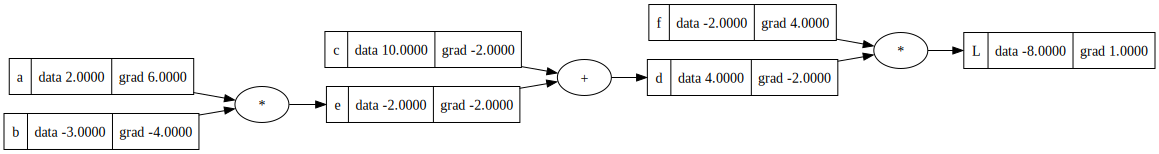

In [157]:
draw_dot(L)

In [73]:
#base case
L.grad = 1.0

In [86]:
#manual backpropagation
d.grad = -2.0
f.grad = 4.0
f.data = -2.0
c.data = 10.0
e.data = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0   

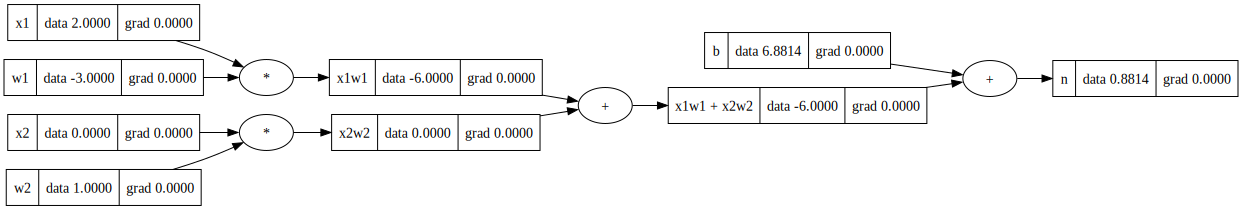

In [160]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n' 
o = n.tanh(); o.label='o'
draw_dot(n)


In [144]:
o.grad = 1.0

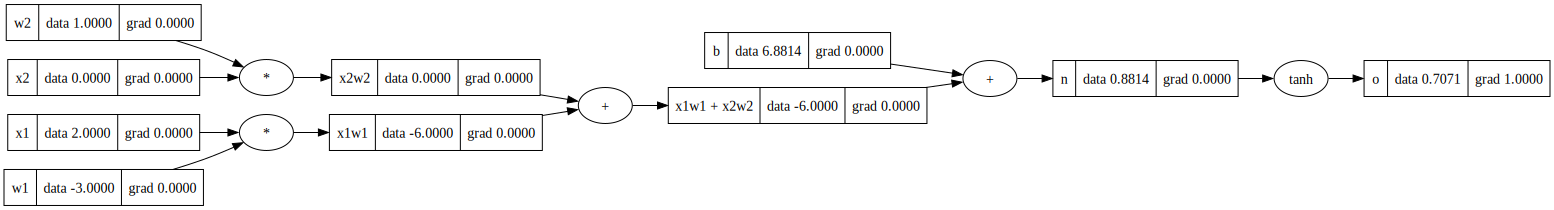

In [129]:
draw_dot(o)

In [165]:
n.grad = .5

In [166]:
b.grad = .5

In [167]:
x1w1x2w2.grad = .5 

In [168]:
x1w1.grad =   .5

In [169]:
x2w2.grad =   .5

In [170]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [171]:
o._backward()

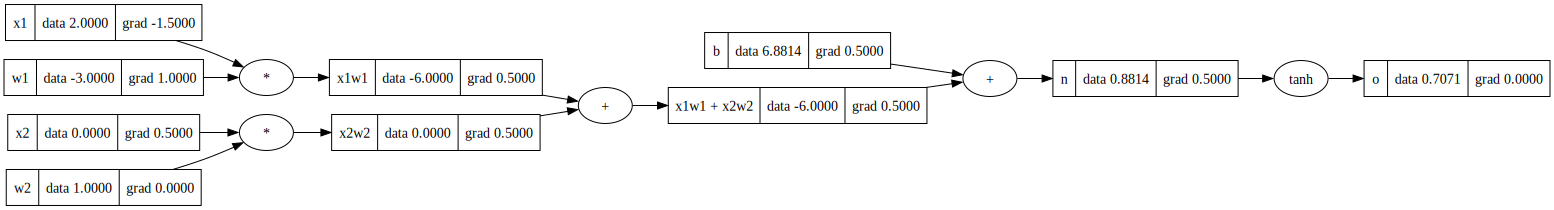

In [172]:
draw_dot(o)

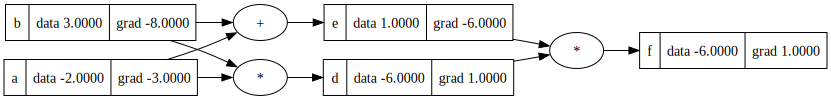

In [156]:
#sample counterexample to a bug
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)